In [123]:
%load_ext autoreload
%autoreload complete

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tqdm.notebook import tqdm

from protest_impact.util import cache, project_root

set_matplotlib_formats("svg")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/6 [00:00<?, ?it/s]

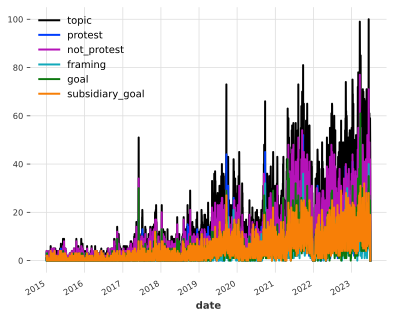

In [124]:
from darts import TimeSeries

from protest_impact.data.news import counts_for_region
from protest_impact.data.protests.keywords import climate_queries

variates = dict()
for qname, query in tqdm(climate_queries().items()):
    news = counts_for_region("Berlin", query, "mediacloud")
    news = news.set_index("date")
    variates[qname] = news["count"]
news = pd.concat(variates, axis=1)
news = TimeSeries.from_dataframe(news)
news.plot()

In [151]:
from collections import Counter
from itertools import chain

from protest_impact.data.protests import load_climate_protests_with_labels

protests = load_climate_protests_with_labels()
protests["size_gpreg_pre"] = protests.apply(
    lambda x: x["size_pre"] if x["source"] == "gpreg" else np.nan, axis=1
)
protests["size_gpreg_post"] = protests.apply(
    lambda x: x["size_post"] if x["source"] == "gpreg" else np.nan, axis=1
)
protests["size_acled"] = protests.apply(
    lambda x: x["size_post"] if x["source"] == "acled" else np.nan, axis=1
)
protests = protests.drop(columns=["size_pre", "size_post", "source"])


def clean_city_name(city: str):
    # clean versions like "Berlin - Mitte", "Hamburg - Inner City", "Berlin - Berlin Mitte"
    return city.split(" - ")[0]


protests["location"] = protests["location"].apply(clean_city_name)
protests["moderate"] = protests["type"].isin(["Peaceful protest"])
protests["radical"] = protests["type"].isin(
    ["Protest with intervention", "Excessive force against protesters"]
)


def agg_size_sum(sizes: list[float]):
    sizes = [s for s in sizes if not pd.isna(s)]
    if len(sizes) == 0:
        return np.nan
    else:
        return sum(sizes)


def agg_size_count(sizes: list[float]):
    sizes = [s for s in sizes if not pd.isna(s)]
    if len(sizes) == 0:
        return np.nan
    else:
        return len(sizes)


def agg_type(types: list[str]):
    types = [t for t in types if not pd.isna(t)]
    pt = [
        "Peaceful protest",
        "Protest with intervention",
        "Excessive force against protesters",
    ]
    if pt[2] in types:
        return pt[2]
    elif pt[1] in types:
        return pt[1]
    elif pt[0] in types:
        return pt[0]
    else:
        return pt[0]


def agg_notes(notes: list[str]):
    notes = [note for note in notes if not pd.isna(note)]
    if len(notes) == 0:
        return np.nan
    else:
        return "; ".join(notes)


def agg_location(locations: list[str]):
    locations = [location for location in locations if not pd.isna(location)]
    if len(locations) == 0:
        return np.nan
    elif len(set(locations)) == 1:
        return locations[0]
    else:
        return "MIXED"


actors = set(chain(*protests.actor.dropna().str.split("; "))) - {"OTHER_CLIMATE_ORG"}
dfs = []
for actor in actors:
    df = (
        protests[protests.actor.str.contains(actor)]
        .groupby(["region", "date"])
        .agg(
            dict(
                type=agg_type,
                notes=agg_notes,
                size_gpreg_pre=[agg_size_sum, agg_size_count],
                size_gpreg_post=[agg_size_sum, agg_size_count],
                size_acled=[agg_size_sum, agg_size_count],
                country="first",
                location=agg_location,
                moderate="any",
                radical="any",
            )
        )
        .reset_index()
    )
    df["actor"] = actor
    dfs.append(df)
protests = pd.concat(dfs)
# flatten multiindex
protests = protests.set_axis(
    [".".join(col).strip() for col in protests.columns.values], axis=1
)
protests = protests.rename(
    columns={
        "size_gpreg_pre.agg_size_sum": "size_gpreg_pre",
        "size_gpreg_pre.agg_size_count": "count_gpreg_pre",
        "size_gpreg_post.agg_size_sum": "size_gpreg_post",
        "size_gpreg_post.agg_size_count": "count_gpreg_post",
        "size_acled.agg_size_sum": "size_acled",
        "size_acled.agg_size_count": "count_acled",
    }
)
# remove ".sum" etc. from the column names
protests = protests.rename(
    columns={col: col.split(".")[0] for col in protests.columns.values}
)

ts = dict()
for region, actor in protests[["region", "actor"]].drop_duplicates().values:
    ts_ = protests[(protests.region == region) & (protests.actor == actor)].set_index(
        "date"
    )
    ts_ = ts_.drop(columns=["country", "location", "region", "actor", "type", "notes"])
    ts[(region, actor)] = TimeSeries.from_dataframe(
        ts_, fill_missing_dates=True, freq="D"
    )
ts[("Berlin", "FFF")].plot()

,region,date,type,notes,size_gpreg_pre,count_gpreg_pre,size_gpreg_post,count_gpreg_post,size_acled,count_acled,country,location,moderate,radical,actor
346,Berlin,2019-11-15,Peaceful protest,Fridays For Future ‐ Klimastreik (vom 18.10. b...,510.0,4.0,63.0,4.0,NaN,NaN,Germany,Berlin,False,False,FFF
446,Wien,2023-04-17,Protest with intervention,"On 17 April 2023, between 15 and 20 members of...",NaN,NaN,NaN,NaN,17.0,1.0,Austria,Vienna,False,True,ALG
157,Bayern,2021-02-21,Peaceful protest,Mahnwache für den Klimaschutz,10.0,1.0,NaN,NaN,NaN,NaN,Germany,Munchen,False,False,FFF
1321,Wien,2022-11-26,Peaceful protest,"On 26 November 2022, people, at the call of FF...",NaN,NaN,NaN,NaN,NaN,NaN,Austria,Vienna,True,False,FFF
7,Baden-Württemberg,2022-06-01,Peaceful protest,"On 1 June 2022, around 70 people, including me...",NaN,NaN,NaN,NaN,70.0,1.0,Germany,Mannheim,True,False,ALG


In [166]:
# use gpreg_post values where available, and otherwise gpreg_pre
protests["size_gpreg"] = protests.apply(
    lambda x: x["size_gpreg_post"]
    if not pd.isna(x["size_gpreg_post"])
    else x["size_gpreg_pre"],
    axis=1,
)

Text(0, 0.5, 'size_acled')

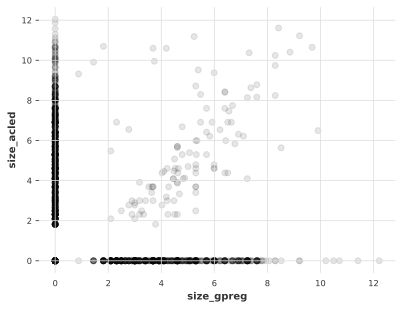

In [167]:
protests["size_gpreg"] = protests["size_gpreg"].fillna(0)
protests["size_acled"] = protests["size_acled"].fillna(0)
plt.scatter(
    np.arcsinh(protests["size_gpreg"]), np.arcsinh(protests["size_acled"]), alpha=0.1
)
plt.xlabel("size_gpreg")
plt.ylabel("size_acled")

[[ 735  113]
 [ 635 1002]]
[[0.29577465 0.04547284]
 [0.2555332  0.40321932]]


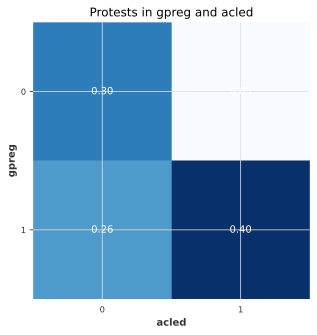

In [168]:
# make a matrix whether the size is > 0 in gpreg, in acled, in both, or in neither
gpreg_only = protests[(protests["size_gpreg"] > 0) & (protests["size_acled"] == 0)]
acled_only = protests[(protests["size_gpreg"] == 0) & (protests["size_acled"] > 0)]
both = protests[(protests["size_gpreg"] > 0) & (protests["size_acled"] > 0)]
neither = protests[(protests["size_gpreg"] == 0) & (protests["size_acled"] == 0)]

matrix = np.array(
    [
        [len(gpreg_only), len(both)],
        [len(neither), len(acled_only)],
    ]
)
print(matrix)
matrix = matrix / matrix.sum()
print(matrix)

# plot the matrix
fig, ax = plt.subplots()
im = ax.imshow(matrix, cmap="Blues")
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xlabel("acled")
ax.set_ylabel("gpreg")
ax.set_title("Protests in gpreg and acled")
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, f"{matrix[i, j]:.2f}", ha="center", va="center", color="w")
fig.tight_layout()
plt.show()

In [155]:
for region, country in protests[["region", "country"]].drop_duplicates().values:
    print(region, country)

Baden-Württemberg Germany
Bayern Germany
Berlin Germany
Brandenburg Germany
Bremen Germany
Hamburg Germany
Hessen Germany
Karnten Austria
Mecklenburg-Vorpommern Germany
Niedersachsen Germany
Nordrhein-Westfalen Germany
Oberosterreich Austria
Rheinland-Pfalz Germany
Saarland Germany
Sachsen Germany
Sachsen-Anhalt Germany
Salzburg Austria
Schleswig-Holstein Germany
Steiermark Austria
Thüringen Germany
Tirol Austria
Vorarlberg Austria
Wien Austria
Bern Switzerland
Geneve Switzerland
Ticino Switzerland
Vaud Switzerland
Fribourg Switzerland
Neuchatel Switzerland
Niederosterreich Austria
Zurich Switzerland
Aargau Switzerland
Appenzell Ausserrhoden Switzerland
Basel-Stadt Switzerland
Burgenland Austria
Graubunden Switzerland
Luzern Switzerland
St. Gallen Switzerland
Valais Switzerland
